In [1]:
import itertools
import numpy as np
import pandas as pd
import umap

from transformers import AutoTokenizer, AutoModel
from nltk.tokenize import word_tokenize

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from matplotlib import pyplot as plt

from source.ML.HelperFunction import batch_iterator
from source.Topic.Preprocessing import f_noun
from source.Topic.Utils import plot_proj

In [2]:
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-german-cased")
model = AutoModel.from_pretrained("dbmdz/bert-base-german-cased")

def bert_vec(sentences):
    batch_vec = []
    for batch, (batch_start, batch_size) in enumerate(batch_iterator(len(sentences), 10)):
        output, pooled = model(**tokenizer(sentences[batch_start: batch_start + batch_size], padding=True, truncation=True, return_tensors="pt"))
        batch_vec.append(pooled.detach().numpy())
    return np.vstack(batch_vec)

In [3]:
meta = pd.read_csv("kaffee_reviews.csv")
meta.drop(columns=["index"], inplace=True)

In [4]:
words = np.unique(f_noun(word_tokenize(meta.review[0]), lang="german")).tolist()
foo = bert_vec(words)

In [5]:
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(foo)

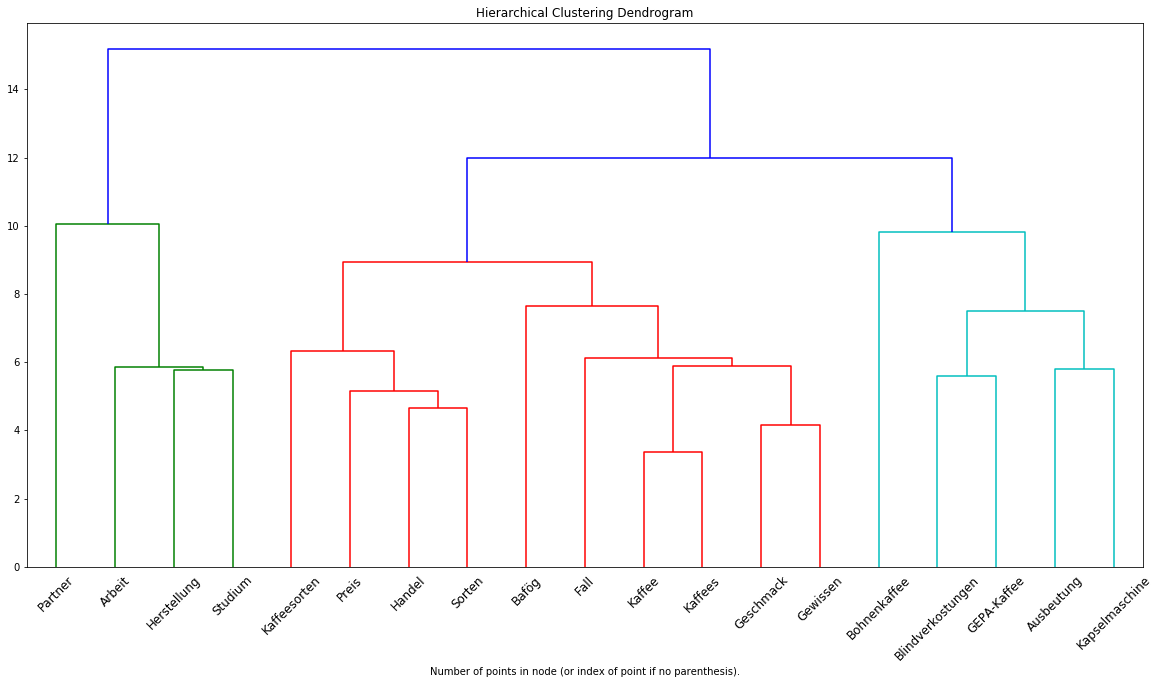

In [15]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.figure(figsize=(20, 10))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(clustering, truncate_mode='level', p=0, labels=words, leaf_rotation=45)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")

plt.show()

In [7]:
ii = itertools.count(foo.shape[0])
bar = [{'node_id': next(ii), 'left': words[x[0]] if x[0] < len(words) else x[0], 'right':words[x[1]] if x[1] < len(words) else x[1]} for x in clustering.children_]
bar

[{'node_id': 19, 'left': 'Kaffee', 'right': 'Kaffees'},
 {'node_id': 20, 'left': 'Geschmack', 'right': 'Gewissen'},
 {'node_id': 21, 'left': 'Handel', 'right': 'Sorten'},
 {'node_id': 22, 'left': 'Preis', 'right': 21},
 {'node_id': 23, 'left': 'Blindverkostungen', 'right': 'GEPA-Kaffee'},
 {'node_id': 24, 'left': 'Herstellung', 'right': 'Studium'},
 {'node_id': 25, 'left': 'Ausbeutung', 'right': 'Kapselmaschine'},
 {'node_id': 26, 'left': 'Arbeit', 'right': 24},
 {'node_id': 27, 'left': 19, 'right': 20},
 {'node_id': 28, 'left': 'Fall', 'right': 27},
 {'node_id': 29, 'left': 'Kaffeesorten', 'right': 22},
 {'node_id': 30, 'left': 23, 'right': 25},
 {'node_id': 31, 'left': 'Bafög', 'right': 28},
 {'node_id': 32, 'left': 29, 'right': 31},
 {'node_id': 33, 'left': 'Bohnenkaffee', 'right': 30},
 {'node_id': 34, 'left': 'Partner', 'right': 26},
 {'node_id': 35, 'left': 32, 'right': 33},
 {'node_id': 36, 'left': 34, 'right': 35}]

Calculating UMAP projection ...
Calculating UMAP projection. Done!


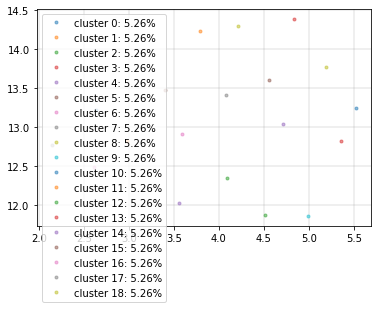

In [73]:
reducer = umap.UMAP()
print('Calculating UMAP projection ...')
vec_umap = reducer.fit_transform(foo)
print('Calculating UMAP projection. Done!')
plot_proj(vec_umap, clustering.labels_)

